https://data.open-power-system-data.org/household_data/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

original_directory = os.getcwd()
os.chdir('..')

from functions_to_sample import *
from util import *

np.random.seed(42)
random.seed(42)

os.chdir(original_directory)

In [2]:
num_agents = 10

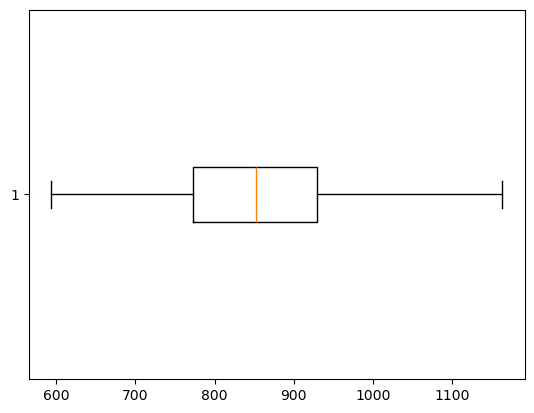

In [3]:
with open('../input_files/simulation_3_periods.pickle', 'rb') as file:
    # Step 2: Load the contents of the file into a Python dictionary
    results = pickle.load(file)

weleclist = []
for key in results.keys():
    weleclist.append(results[key]['welec'].sum())

welec = np.array(weleclist)
plt.boxplot(welec, vert=False)
plt.show()

In [4]:
# Load data and set index
df = pd.read_csv('household_data_60min_singleindex.csv')
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
df.set_index('utc_timestamp', inplace=True)

# Filter data for days of the year between 10 and 40
residential_columns = df.columns[df.columns.str.contains('residential')]
res_data = df[residential_columns]
res_data = res_data[(res_data.index.dayofyear >= 10) & (res_data.index.dayofyear <= 40)]
# res_data = res_data[(res_data.index.dayofyear >= 150) & (res_data.index.dayofyear <= 180)]

# Function to simplify column names
def simplify_column_names(df, appliance):
    df.columns = [col.replace('DE_KN_', '').replace('residential', 'R').replace(appliance, '') for col in df.columns]
    return df

def adjust_for_years(df):
    df = df.copy()
    df.loc[:, 'year'] = df.index.year
    df.loc[:, 'month'] = df.index.month
    df.loc[:, 'day'] = df.index.day
    df.loc[:, 'hour'] = df.index.hour
    pivot_df = df.pivot_table(index=['month', 'day', 'hour'], columns='year')
    return pivot_df




# Applying transformations
appliances = ['washing_machine', 'circulation_pump', 'freezer', 'dishwasher', 'pv',
              'grid_import', 'grid_export', 'refrigerator', 'heat_pump', 'ev']

processed_dfs = {}
for appliance in appliances:
    filtered_df = simplify_column_names(res_data.filter(regex=f'{appliance}$'), appliance)
    if not filtered_df.empty:
        processed_dfs[appliance] = adjust_for_years(filtered_df)
        processed_dfs[appliance].dropna(axis=1, inplace=True)
        new_columns = [''.join(map(str, col)) for col in processed_dfs[appliance].columns]
        processed_dfs[appliance].columns = new_columns
        processed_dfs[appliance] = processed_dfs[appliance].diff()
        processed_dfs[appliance].iloc[0] = 0

    idx_df = processed_dfs[appliance].index.to_frame(index=False)
    idx_df['datetime'] = pd.to_datetime(idx_df.assign(year=2023))  # You can adjust the year as needed
    processed_dfs[appliance].index = pd.DatetimeIndex(idx_df['datetime'])

keys_to_remove = ['grid_import', 'grid_export']
remove_keys = True
if remove_keys:
    for key in keys_to_remove:
        processed_dfs.pop(key, None)  # The None is used to avoid KeyError if the key is not found

# Now 'my_dict' no longer contains the keys 'heat_pump', 'grid_import', and 'grid_export'

processed_dfs.keys()


dict_keys(['washing_machine', 'circulation_pump', 'freezer', 'dishwasher', 'pv', 'refrigerator', 'heat_pump', 'ev'])

In [5]:
def adjust_dataframe_columns(data_dict, num_houses):
    """
    Adjusts the DataFrames in the dictionary to have the specified number of columns and renames the columns.
    
    :param data_dict: Dictionary where each key is an appliance type and each value is a DataFrame of electricity consumption data.
    :param num_houses: The required number of columns (houses) in each DataFrame.
    :return: A new dictionary with adjusted and uniformly named DataFrames.
    """
    adjusted_dict = {}
    for appliance, df in data_dict.items():
        current_columns = df.shape[1]
        if current_columns == num_houses:
            adjusted_df = df.copy()
        elif current_columns > num_houses:
            adjusted_df = df.iloc[:, :num_houses]
        else:
            additional_cols_needed = num_houses - current_columns
            replicated_columns = np.random.choice(df.columns, size=additional_cols_needed, replace=True)
            adjusted_df = pd.concat([df, df[replicated_columns]], axis=1)

        # Rename the columns to have continuous house numbering
        adjusted_df.columns = [f'House_{i+1}' for i in range(num_houses)]
        adjusted_dict[appliance] = adjusted_df

    return adjusted_dict


In [6]:
def create_summed_consumption_df(adjusted_appliances):
    """
    Creates a DataFrame where each column is the sum of electricity consumption
    for each appliance type across all data.

    :param adjusted_appliances: Dictionary with keys as appliance types and values as adjusted DataFrames.
    :return: DataFrame of summed electricity consumption.
    """
    summed_data = {}
    for appliance, df in adjusted_appliances.items():
        # Sum across rows for each house/column
        summed_data[appliance] = df.sum(axis=1)

    # Create a DataFrame from the dictionary of summed values
    consumption_df = pd.DataFrame(summed_data)
    consumption_df['pv'] = - consumption_df['pv']  # Invert the EV values to represent generation
    return consumption_df

In [7]:
adjusted_df = adjust_dataframe_columns(processed_dfs, num_agents)
consumption_df = create_summed_consumption_df(adjusted_df)
consumption_df_day = consumption_df.groupby(consumption_df.index.hour).mean()
total_consumption = consumption_df.sum(axis=1)

# Separate the consumption and PV generation columns
consumption_columns = [col for col in consumption_df_day.columns if col != 'pv' and col != 'net_consumption' and col != 'category']
pv_generation_column = 'pv'

# Calculate net consumption
consumption_df_day['heat_pump'] = results[(21, 21, 21)]['welec'] / 30 * num_agents # divided by days to take mean, and xnum_agents for #agents

# scaling_factor = (results[(20,20,20)]['welec'] / 30 * num_agents).sum() / consumption_df_day['heat_pump'].sum()
# updated_consumption = consumption_df_day['heat_pump'] * scaling_factor
# consumption_df_day['heat_pump'] = updated_consumption

consumption_df_day['net_consumption'] = consumption_df_day[consumption_columns].sum(axis=1) + consumption_df_day[pv_generation_column]

In [8]:
consumption_columns_names = ['Washing Machine', 'Circulation Pump', 'Freezer', 'Dishwasher', 'Refrigerator', 'Heat Pump', 'Electric Vehicle']

# Define a professional color palette
colors = plt.get_cmap('tab20c')(np.linspace(0.05, 0.95, len(consumption_columns)))
time_period_colors = ['blue', 'green', 'red', 'blue']
alpha_periods = 0.1

# Plot Baselines

In [9]:
adjusted_df = adjust_dataframe_columns(processed_dfs, num_agents)
consumption_df = create_summed_consumption_df(adjusted_df)
consumption_df_day = consumption_df.groupby(consumption_df.index.hour).mean()
total_consumption = consumption_df.sum(axis=1)

# Separate the consumption and PV generation columns
consumption_columns = [col for col in consumption_df_day.columns if col != 'pv' and col != 'net_consumption' and col != 'category']
pv_generation_column = 'pv'

# Calculate net consumption
consumption_df_day_20 = consumption_df_day.copy()
consumption_df_day_20['heat_pump'] = results[(20,20,20)]['welec'] / 30 * num_agents # divided by days to take mean, and xnum_agents for #agents
consumption_df_day_20['net_consumption'] = consumption_df_day_20[consumption_columns].sum(axis=1) + consumption_df_day_20[pv_generation_column]

consumption_df_day_21 = consumption_df_day.copy()
consumption_df_day_21['heat_pump'] = results[(21,21,21)]['welec'] / 30 * num_agents # divided by days to take mean, and xnum_agents for #agents
consumption_df_day_21['net_consumption'] = consumption_df_day_21[consumption_columns].sum(axis=1) + consumption_df_day_21[pv_generation_column]

consumption_df_day_22 = consumption_df_day.copy()
consumption_df_day_22['heat_pump'] = results[(22,22,22)]['welec'] / 30 * num_agents # divided by days to take mean, and xnum_agents for #agents
consumption_df_day_22['net_consumption'] = consumption_df_day_22[consumption_columns].sum(axis=1) + consumption_df_day_22[pv_generation_column]

In [10]:
keys = np.array(list(results.keys()))
welec_values = np.vstack([v['welec'] for v in results.values()])
temp_values = np.vstack([v['temp'] for v in results.values()])

interp_welec = LinearNDInterpolator(keys, welec_values)
interp_temp = LinearNDInterpolator(keys, temp_values)

In [39]:
dmabo_inputs

array([[20.31396854, 20.32818862, 21.99999957],
       [22.        , 22.        , 21.98197417],
       [20.11383863, 20.03735596, 22.        ],
       [20.19658724, 21.48268801, 22.        ],
       [21.6096383 , 21.64095884, 21.94617378],
       [21.26039808, 21.55531473, 21.99142934],
       [20.0468777 , 20.8675687 , 22.        ],
       [19.43019876, 21.25164401, 21.8863798 ],
       [19.98381335, 20.98831662, 22.        ],
       [21.98748042, 22.        , 22.        ]])

In [11]:
# MULTI AGENT
dmabo_inputs = np.array([
                        20.31396854, 20.32818862, 21.99999957, 22., 22., 21.98197417,
                        20.11383863, 20.03735596, 22., 20.19658724, 21.48268801, 22.,
                        21.6096383, 21.64095884, 21.94617378, 21.26039808, 21.55531473, 21.99142934,
                        20.0468777, 20.8675687, 22., 19.43019876, 21.25164401, 21.8863798,
                        19.98381335, 20.98831662, 22., 21.98748042, 22., 22.
                    ]).reshape((-1, 3), order='C')


# SINGLE AGENT:

sigopt_inputs = np.array([[20.81171805, 21.06435547, 21.97580792],
       [21.3204375 , 21.74166038, 22.        ],
       [21.31434691, 21.73717508, 21.99442961],
       [21.31077499, 21.7334268 , 21.98960614],
       [21.32043749, 21.74166037, 22.        ],
       [21.32043746, 21.74166037, 22.        ],
       [21.31439439, 21.7372249 , 21.99449373],
       [20.15555144, 20.50870409, 20.51536297],
       [20.91249124, 21.22845482, 22.        ],
       [21.32043748, 21.74166037, 22.        ]])


hp_cons = np.zeros(results[(22,22,22)]['welec'].shape)
hp_cons_per_agent_sg = np.zeros((results[(22,22,22)]['welec'].shape[0],num_agents))

for i, sg_inp in enumerate(sigopt_inputs):
    hp_cons += interp_welec(sg_inp).reshape(-1) / 30
    hp_cons_per_agent_sg[:, i] = interp_welec(sg_inp).reshape(-1) / 30

consumption_df_day_singopt = consumption_df_day.copy()
consumption_df_day_singopt['heat_pump'] = hp_cons
consumption_df_day_singopt['net_consumption'] = consumption_df_day_singopt[consumption_columns].sum(axis=1) + consumption_df_day_singopt[pv_generation_column]



hp_cons_dmabo = np.zeros(results[(22,22,22)]['welec'].shape)
hp_cons_per_agent = np.zeros((results[(22,22,22)]['welec'].shape[0],num_agents))

for i, ma_inp in enumerate(dmabo_inputs):
    hp_cons_dmabo += interp_welec(ma_inp).reshape(-1) / 30
    hp_cons_per_agent[:, i] = interp_welec(ma_inp).reshape(-1) / 30

consumption_df_day_dmabo = consumption_df_day.copy()
consumption_df_day_dmabo['heat_pump'] = hp_cons_dmabo
consumption_df_day_dmabo['net_consumption'] = consumption_df_day_dmabo[consumption_columns].sum(axis=1) + consumption_df_day_dmabo[pv_generation_column]


consumption_df_day['heat_pump'] = results[(21, 21, 21)]['welec'] / 30 * num_agents # divided by days to take mean, and xnum_agents for #agents
consumption_df_day['net_consumption'] = consumption_df_day[consumption_columns].sum(axis=1) + consumption_df_day[pv_generation_column]

In [12]:
hp_per_agent_df = pd.DataFrame(hp_cons_per_agent, index=consumption_df_day.index, columns=[f'Agent_{i+1}' for i in range(num_agents)])
hp_per_agent_df_sg = pd.DataFrame(hp_cons_per_agent_sg, index=consumption_df_day.index, columns=[f'Agent_{i+1}' for i in range(num_agents)])

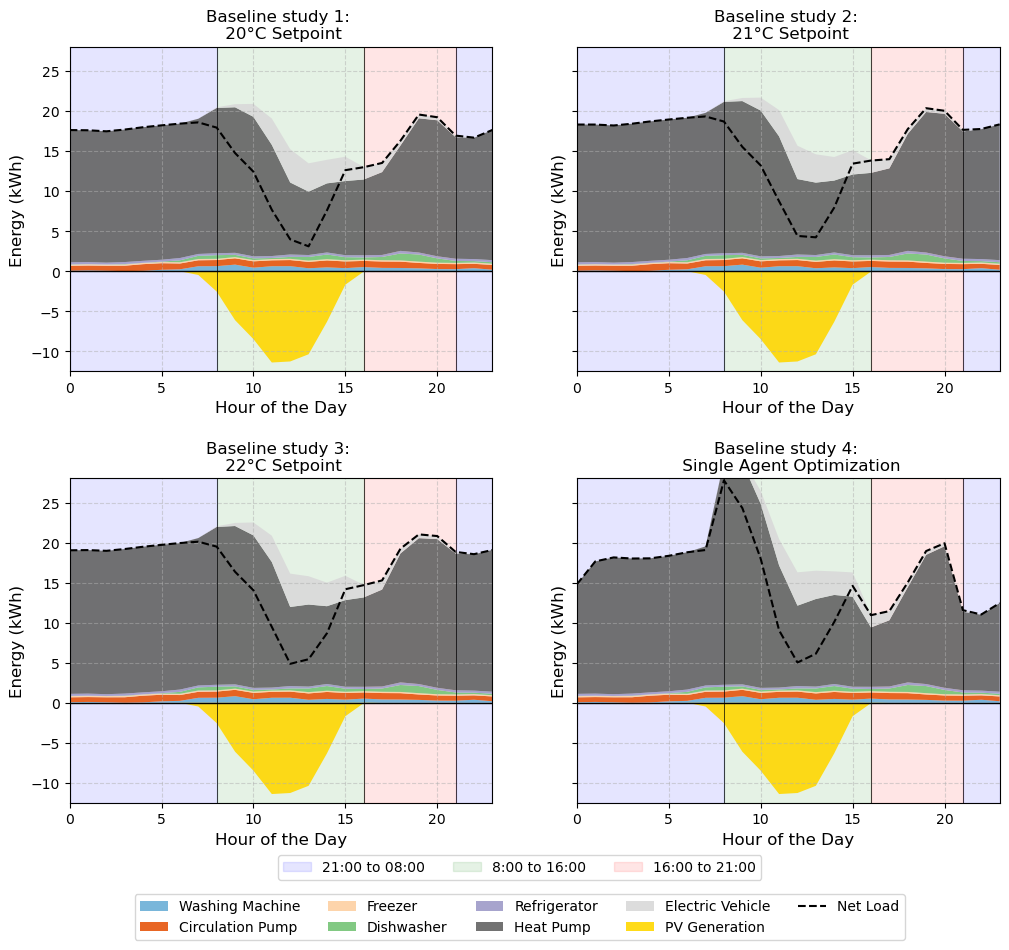

In [13]:
def plot_data(ax, df, title, maxy=28):
    # Highlight different time periods with explanations in the legend

    time_periods = [(0, 8), (8, 16), (16, 21), (21, 23)]
    time_period_labels = ['21:00 to 08:00', '8:00 to 16:00', '16:00 to 21:00', '21:00 to 24:00', '0:00 to 8:00']
    # Apply periods. Note: 21:00 to 8:00 is shown in two parts but can be labeled only once
    for i, (start, end) in enumerate(time_periods):
        if i != 3:  # Prevent duplicate label for 0:00 to 8:00
            ax.axvspan(start, end, color=time_period_colors[i], alpha=alpha_periods, label=time_period_labels[i])
        else:
            ax.axvspan(start, end, color=time_period_colors[i], alpha=alpha_periods, label='_no_legend_')



    # Plot the individual consumption data with labels for legend
    consumption_plots = ax.stackplot(df.index, df[consumption_columns].T, colors=colors, alpha=0.9, labels=consumption_columns_names)

    # Plot the PV generation data (negative for visual purposes)
    pv_plot = ax.stackplot(df.index, df[pv_generation_column], colors=['#FFD700'], alpha=0.9, labels=['PV Generation'])

    # Plot the net consumption data
    net_plot = ax.plot(df.index, df['net_consumption'], label='Net Load', color='black', linestyle='--')

    # Reference lines (not in legend)
    ax.axhline(0, color='black', linewidth=1, label='_no_legend_')
    ax.axvline(8, color='black', linewidth=0.5, label='_no_legend_')
    ax.axvline(16, color='black', linewidth=0.5, label='_no_legend_')
    ax.axvline(21, color='black', linewidth=0.5, label='_no_legend_')

    # Setting x and y limits
    ax.set_xlim(0, 23)
    ax.set_ylim(-12.5, maxy)

    # Enhancing the chart with a title, labels, and grid
    ax.set_title(title)
    ax.set_xlabel('Hour of the Day', fontsize=12)
    ax.set_ylabel('Energy (kWh)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)

# Setup figure with three subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

# Plot data on each subplot
plot_data(ax1, consumption_df_day_20, 'Baseline study 1: \n 20°C Setpoint')
plot_data(ax2, consumption_df_day_21, 'Baseline study 2: \n 21°C Setpoint')
plot_data(ax3, consumption_df_day_22, 'Baseline study 3: \n 22°C Setpoint')
plot_data(ax4, consumption_df_day_singopt, 'Baseline study 4: \n Single Agent Optimization')

# Collect handles and labels for legends
handles, labels = ax1.get_legend_handles_labels()

# Create two separate legends
fig.legend(handles[:3], labels[:3], loc='lower center', bbox_to_anchor=(0.5, 0.18), ncol=4, fontsize=10)  # Time periods
fig.legend(handles[3:], labels[3:], loc='lower center', bbox_to_anchor=(0.5, 0.13), ncol=5, fontsize=10)  # Appliances and PV generation

# Adjust layout
fig.subplots_adjust(bottom=0.25, hspace=0.33)  # 'hspace' controls the vertical spacing


fig.savefig('baseline_welec.png', bbox_inches='tight')

# Show the plot
plt.show()

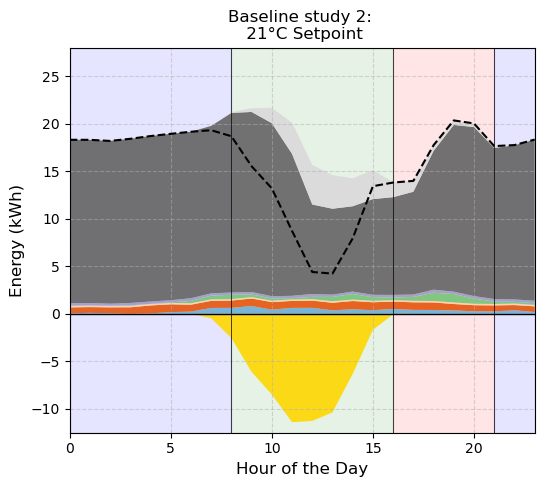

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), sharey=True)

# Plot data on each subplot
plot_data(ax, consumption_df_day_21, 'Baseline study 2: \n 21°C Setpoint')


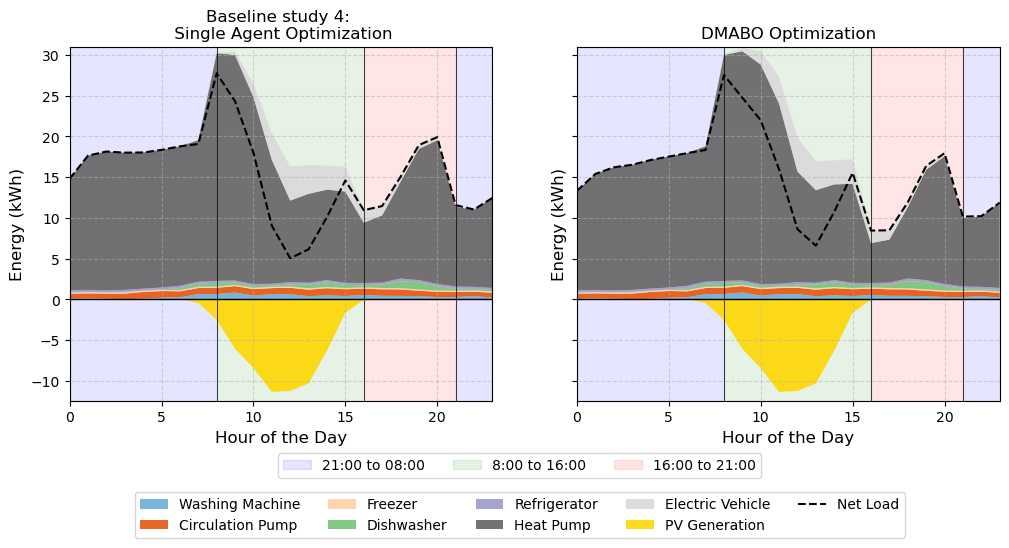

In [15]:
# Setup figure with three subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot data on each subplot
plot_data(ax1, consumption_df_day_singopt, 'Baseline study 4: \n Single Agent Optimization', maxy=31)
plot_data(ax2, consumption_df_day_dmabo, 'DMABO Optimization', maxy=31)

# Collect handles and labels for legends
handles, labels = ax1.get_legend_handles_labels()

# Create two separate legends
fig.legend(handles[:3], labels[:3], loc='lower center', bbox_to_anchor=(0.5, 0.15), ncol=4, fontsize=10)  # Time periods
fig.legend(handles[3:], labels[3:], loc='lower center', bbox_to_anchor=(0.5, 0.05), ncol=5, fontsize=10)  # Appliances and PV generation

# Adjust layout
fig.subplots_adjust(bottom=0.29, hspace=0.33)  # 'hspace' controls the vertical spacing


fig.savefig('dmabo_welec.png', bbox_inches='tight')

# Show the plot
plt.show()

In [16]:
consumption_df_day['category'] = consumption_df_day.index.map(categorize_time)
# Group by the category and calculate the mean consumption for each category
consumption_by_category = consumption_df_day.groupby('category').sum() * 30
consumption_by_category['other_appliances'] = consumption_by_category['net_consumption'] - consumption_by_category['heat_pump'] - consumption_by_category['pv']
consumption_by_category

,washing_machine,circulation_pump,freezer,dishwasher,pv,refrigerator,heat_pump,ev,net_consumption,other_appliances
category,,,,,,,,,,
0,66.010645,222.680323,51.355161,42.480968,-13.942258,83.220968,5635.179056,6.683226,6093.668088,472.431290
1,59.893548,110.121290,23.649677,89.201613,-1.237742,41.108710,2130.207115,125.251935,2578.196147,449.226774
2,132.561290,190.611290,37.341290,81.877742,-1743.165484,61.501935,3253.562865,571.178710,2585.469639,1075.072258


In [17]:
other_consumption = consumption_by_category[['pv', 'other_appliances']]
consumption_by_category.drop(['net_consumption', 'other_appliances'], axis=1) 

,washing_machine,circulation_pump,freezer,dishwasher,pv,refrigerator,heat_pump,ev
category,,,,,,,,
0,66.010645,222.680323,51.355161,42.480968,-13.942258,83.220968,5635.179056,6.683226
1,59.893548,110.121290,23.649677,89.201613,-1.237742,41.108710,2130.207115,125.251935
2,132.561290,190.611290,37.341290,81.877742,-1743.165484,61.501935,3253.562865,571.178710


In [18]:
consumption_by_category['net_consumption']

category
0    6093.668088
1    2578.196147
2    2585.469639
Name: net_consumption, dtype: float64

In [19]:
hp_per_agent_cattime_df = (hp_per_agent_df.groupby(hp_per_agent_df.index.map(categorize_time)).sum() * 30)
other_cons_per_ag = (other_consumption / num_agents).sum(axis=1).values
overall_per_ag = hp_per_agent_cattime_df.add(other_cons_per_ag, axis=0)
overall_per_ag_hourly = overall_per_ag.div(consumption_df_day['category'].value_counts().sort_index().values, axis=0)

In [20]:
hp_per_agent_sg_cattime_df = (hp_per_agent_df_sg.groupby(hp_per_agent_df_sg.index.map(categorize_time)).sum() * 30)
overall_per_ag = hp_per_agent_sg_cattime_df.add(other_cons_per_ag, axis=0)
overall_per_ag_sg_hourly = overall_per_ag.div(consumption_df_day['category'].value_counts().sort_index().values, axis=0)

To balance, we want to decrease a bit the mean hourly consumption, the total is harder to look at

In [21]:
mean_net_consumption = consumption_by_category['net_consumption'] / consumption_df_day['category'].value_counts().sort_index()
mean_net_consumption

category
0    553.969826
1    515.639229
2    323.183705
dtype: float64

In [22]:
moderating_factor = 0.75
adjusted_values = mean_net_consumption + (mean_net_consumption.mean() - mean_net_consumption) * moderating_factor
for i in range(len(adjusted_values)):
    adjusted_values[i] = max(adjusted_values)
adjusted_values

category
0    486.690647
1    486.690647
2    486.690647
dtype: float64

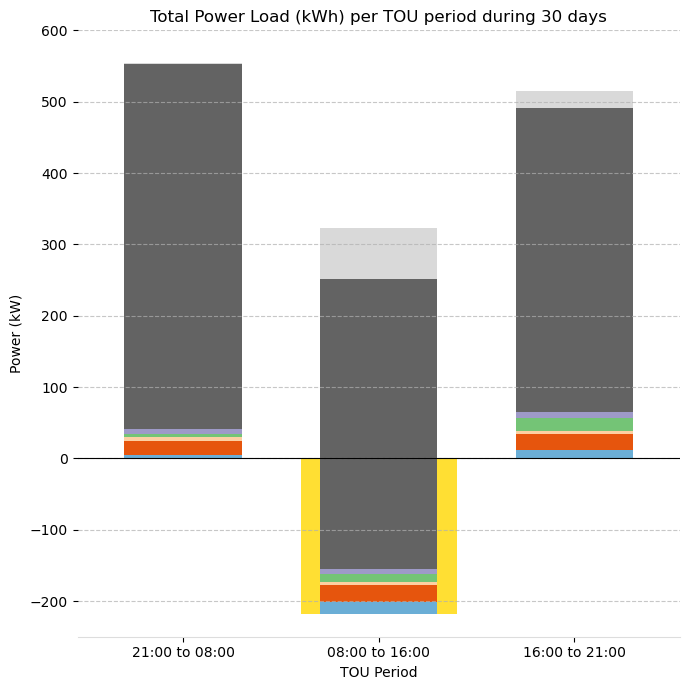

In [23]:
def plot_kwh_TOU(ax, df, power = False, lines=False):
    # Assuming 'consumption_by_category', 'consumption_columns_names', and 'colors' are defined
    df = consumption_by_category.drop(['net_consumption', 'other_appliances'], axis=1)

    if power:
        df.iloc[0] = df.iloc[0] / consumption_df_day['category'].value_counts().sort_index()[0]
        df.iloc[1] = df.iloc[1] / consumption_df_day['category'].value_counts().sort_index()[1]
        df.iloc[2] = df.iloc[2] / consumption_df_day['category'].value_counts().sort_index()[2]

    df = df.iloc[[0,2,1]].reset_index(drop=True)

    # Use a more appealing color for the bars
    ax.bar(df.index, df['pv'], color='#FFD700', alpha=0.8, width=0.8)

    # Stacking bar plot for each appliance, starting with pv as the base
    bottom_values = df['pv'].values
    categories = df.columns.drop('pv')

    for i, category in enumerate(categories):
        ax.bar(df.index, df[category], bottom=bottom_values, color=colors[i], width=0.6)
        bottom_values += df[category].values

    if lines:
        # Specify the heights for the dashed lines
        line_heights = adjusted_values.values

        # Adding dashed lines at specified heights
        ax.plot([- 0.4, 2.4], [line_heights[0], line_heights[0]], 'k--', lw=2, label = 'Adjusted Limit')  # Adjust the x values to align with your bars

    # Customize the plot to make it more visually appealing
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#dddddd')

    ax.axhline(0, color='black', linewidth=0.8)  # Line at y=0
    ax.set_xlabel('TOU Period')

    # Set custom x-axis tick labels
    if power:
        plt.ylim(-250, 600)
        ax.set_title('Total Power Load (kWh) per TOU period during 30 days')
        ax.set_ylabel('Power (kW)')

    else:
        plt.ylim(-2000, 6500)
        ax.set_title('Total Energy Consumption (kWh) per TOU period during 30 days')
        ax.set_ylabel('Energy (kWh)')

    ax.set_xticks(df.index)
    ax.set_xticklabels(['21:00 to 08:00', '08:00 to 16:00', '16:00 to 21:00'])
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

fig, ax = plt.subplots(figsize=(7, 7))

plot_kwh_TOU(ax, consumption_by_category, power=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


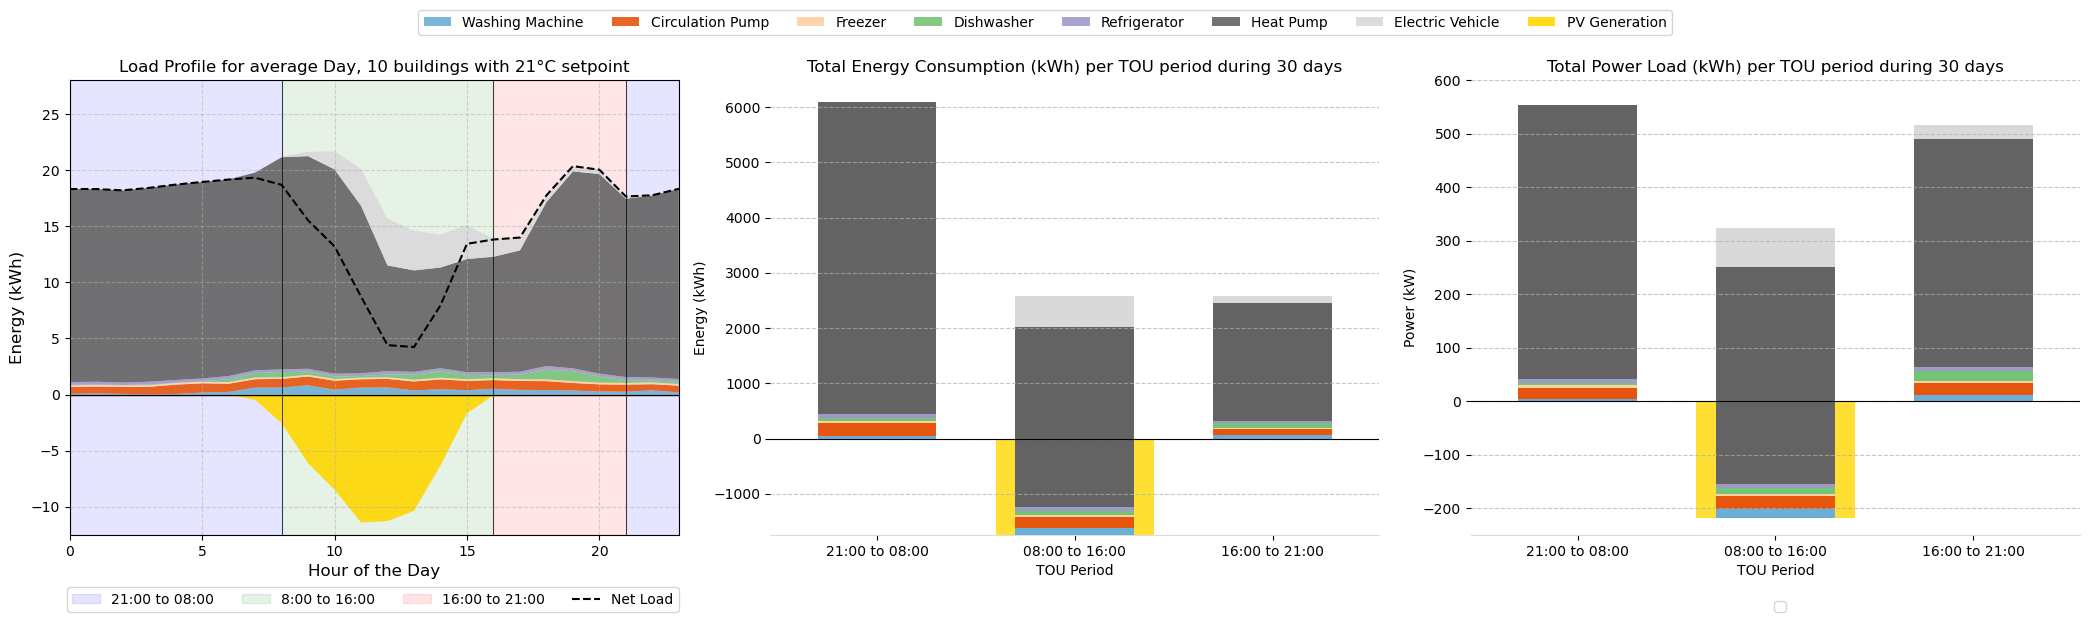

In [24]:
from matplotlib.patches import FancyBboxPatch
# Setup figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7), sharey=False)

# Plot data on each subplot
plot_data(ax1, consumption_df_day_21, 'Load Profile for average Day, 10 buildings with 21°C setpoint')
plot_kwh_TOU(ax2, consumption_by_category, power=False)
plot_kwh_TOU(ax3, consumption_by_category, power=True)

# Collect handles and labels for legends
handles, labels = ax1.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()

# Create two separate legends
fig.legend(handles[:3] + [handles[-1]], labels[:3] + [labels[-1]], loc='lower center', bbox_to_anchor=(0.18, 0.18), ncol=4, fontsize=10)  # Time periods
fig.legend(handles[3:-1], labels[3:-1], loc='upper center', bbox_to_anchor=(0.5, 1.06), ncol=10, fontsize=10)  # Appliances and PV generation
fig.legend(handles3, labels3, loc='lower center', bbox_to_anchor=(0.85, 0.18), ncol=10, fontsize=10)  # Appliances and PV generation

# Adjust layout
fig.subplots_adjust(bottom=0.3)  # Provide enough space for the legend

for ax in [ax1, ax2, ax3]:
    ax.set_facecolor('white')  # Set the background color of the subplots

fig.savefig('setpoints_welec.eps', format='eps', bbox_inches='tight')
fig.savefig('setpoints_welec.png', bbox_inches='tight')

# Show the plot
plt.show()

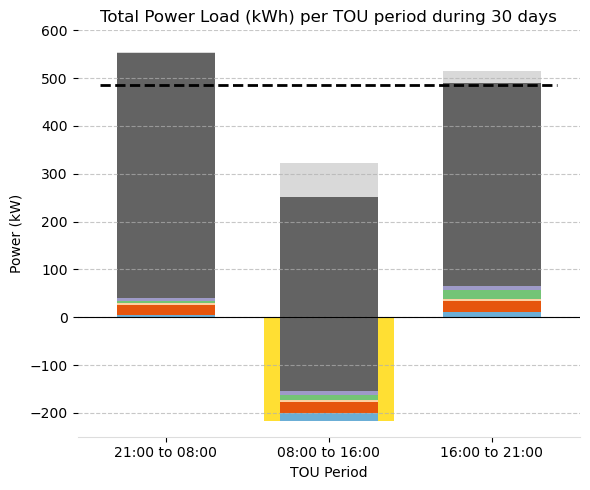

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), sharey=True)

# Plot data on each subplot
plot_kwh_TOU(ax, consumption_by_category, power=True, lines=True)

In [26]:
new_net = adjusted_values * consumption_df_day['category'].value_counts().sort_index()
new_net

category
0    5353.597113
1    2433.453233
2    3893.525173
dtype: float64

In [27]:
new_constraints = new_net - ( consumption_by_category['other_appliances'] + consumption_by_category['pv'] )
new_constraints

category
0    4895.108081
1    1985.464201
2    4561.618399
dtype: float64

In [28]:
new_constraints.values

array([4895.10808108, 1985.46420108, 4561.61839914])

# Updated with New Heat Pump Consumption

In [29]:
hour_20 = consumption_df_day_20['net_consumption'].groupby(consumption_df_day['category']).sum() * 30 / consumption_df_day['category'].value_counts().sort_index()
hour_21 = consumption_df_day_21['net_consumption'].groupby(consumption_df_day['category']).sum() * 30 / consumption_df_day['category'].value_counts().sort_index()
hour_22 = consumption_df_day_22['net_consumption'].groupby(consumption_df_day['category']).sum() * 30 / consumption_df_day['category'].value_counts().sort_index()
hour_singopt = consumption_df_day_singopt['net_consumption'].groupby(consumption_df_day['category']).sum() * 30 / consumption_df_day['category'].value_counts().sort_index()
hour_dmabo = consumption_df_day_dmabo['net_consumption'].groupby(consumption_df_day['category']).sum() * 30 / consumption_df_day['category'].value_counts().sort_index()

hour_20 = hour_20[[0,2,1]].reset_index(drop=True)
hour_20.index = ['21:00 to 08:00', '08:00 to 16:00', '16:00 to 21:00']

hour_21 = hour_21[[0,2,1]].reset_index(drop=True)
hour_21.index = ['21:00 to 08:00', '08:00 to 16:00', '16:00 to 21:00']

hour_22 = hour_22[[0,2,1]].reset_index(drop=True)
hour_22.index = ['21:00 to 08:00', '08:00 to 16:00', '16:00 to 21:00']

hour_singopt = hour_singopt[[0,2,1]].reset_index(drop=True)
hour_singopt.index = ['21:00 to 08:00', '08:00 to 16:00', '16:00 to 21:00']

hour_dmabo = hour_dmabo[[0,2,1]].reset_index(drop=True)
hour_dmabo.index = ['21:00 to 08:00', '08:00 to 16:00', '16:00 to 21:00']

In [30]:
new_net  / consumption_df_day['category'].value_counts().sort_index()

category
0    486.690647
1    486.690647
2    486.690647
dtype: float64

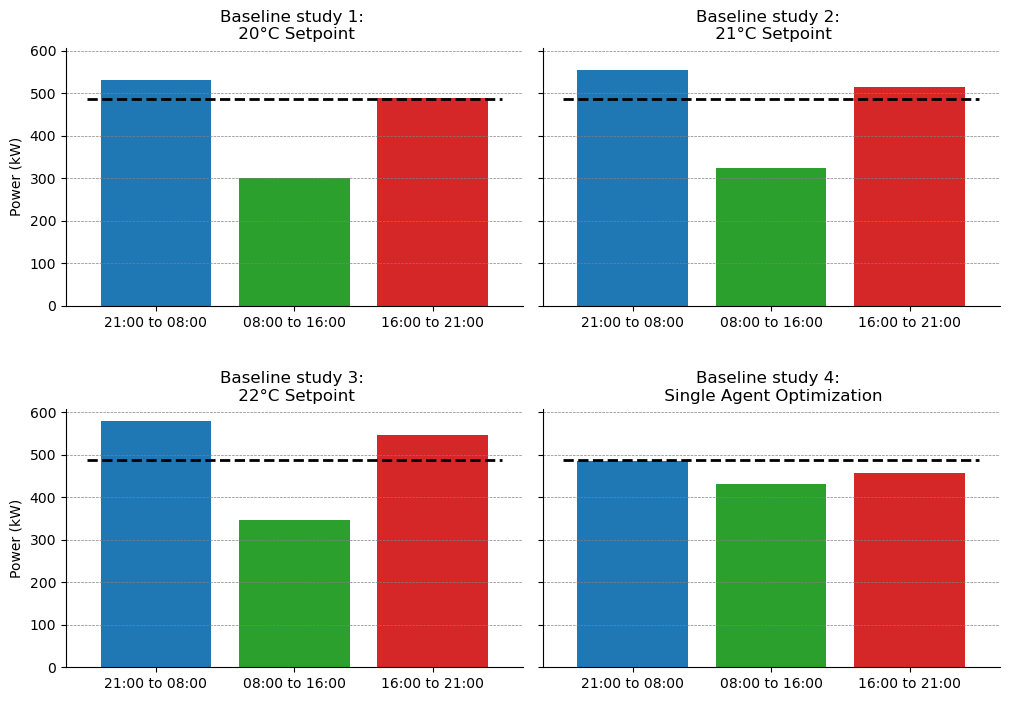

In [31]:
import matplotlib.pyplot as plt

# Assume hour_20, hour_21, hour_22, hour_singopt are pandas Series or DataFrames
# Colors for each category index
colors = ['#1f77b4', '#2ca02c', '#d62728']  # more professional color scheme

# Create subplots with shared y-axis
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharey=True)

# Set the width of the bars to a higher value
bar_width = 0.8  # Adjust this value as needed to make bars thicker and closer

# Plot each series in a subplot with specified colors for each category index
hour_20.plot(kind='bar', ax=axes[0, 0], color=colors, title='Baseline study 1: \n 20°C Setpoint', width=bar_width)
hour_21.plot(kind='bar', ax=axes[0, 1], color=colors, title='Baseline study 2: \n 21°C Setpoint', width=bar_width)
hour_22.plot(kind='bar', ax=axes[1, 0], color=colors, title='Baseline study 3: \n 22°C Setpoint', width=bar_width)
hour_singopt.plot(kind='bar', ax=axes[1, 1], color=colors, title='Baseline study 4: \n Single Agent Optimization', width=bar_width)

line_heights = adjusted_values.values

# Adding dashed lines at specified heights
axes[0, 0].plot([- 0.5, 2.5], [line_heights[0], line_heights[0]], 'k--', lw=2, label='Adjusted Limit')
axes[0, 1].plot([- 0.5, 2.5], [line_heights[0], line_heights[0]], 'k--', lw=2, label='Adjusted Limit')
axes[1, 0].plot([- 0.5, 2.5], [line_heights[0], line_heights[0]], 'k--', lw=2, label='Adjusted Limit')
axes[1, 1].plot([- 0.5, 2.5], [line_heights[0], line_heights[0]], 'k--', lw=2, label='Adjusted Limit')

# Layout adjustment with reduced horizontal space
plt.tight_layout()  # Adjust the h_pad to reduce spacing
fig.subplots_adjust(hspace=0.4)  # Lower value means less space

# Remove top and right spines and add horizontal grid lines for all subplots
for ax in axes.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray', axis='y')
    ax.set_ylabel('Power (kW)')

fig.savefig('bars_baselines_power.eps', format='eps', bbox_inches='tight')

plt.show()


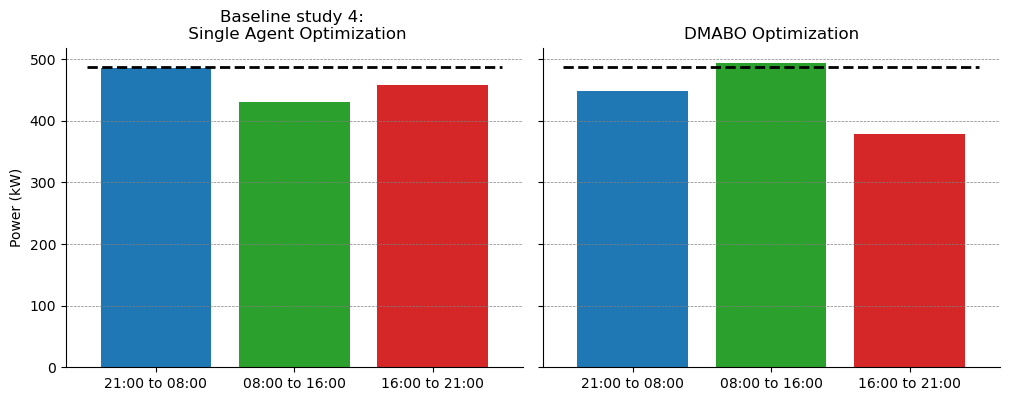

In [32]:
import matplotlib.pyplot as plt

# Assume hour_20, hour_21, hour_22, hour_singopt are pandas Series or DataFrames
# Colors for each category index
colors = ['#1f77b4', '#2ca02c', '#d62728']  # more professional color scheme

# Create subplots with shared y-axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

# Set the width of the bars to a higher value
bar_width = 0.8  # Adjust this value as needed to make bars thicker and closer

# Plot each series in a subplot with specified colors for each category index
hour_singopt.plot(kind='bar', ax=axes[0], color=colors, title='Baseline study 4: \n Single Agent Optimization', width=bar_width)
hour_dmabo.plot(kind='bar', ax=axes[1], color=colors, title='DMABO Optimization', width=bar_width)

line_heights = adjusted_values.values

# Adding dashed lines at specified heights
axes[0].plot([- 0.5, 2.5], [line_heights[0], line_heights[0]], 'k--', lw=2, label='Adjusted Limit')
axes[1].plot([- 0.5, 2.5], [line_heights[0], line_heights[0]], 'k--', lw=2, label='Adjusted Limit')

# Layout adjustment with reduced horizontal space
plt.tight_layout()  # Adjust the h_pad to reduce spacing
fig.subplots_adjust(hspace=0.4)  # Lower value means less space

# Remove top and right spines and add horizontal grid lines for all subplots
for ax in axes.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray', axis='y')
    ax.set_ylabel('Power (kW)')

fig.savefig('bars_dmabo_power.eps', format='eps', bbox_inches='tight')

plt.show()


In [33]:
overall_per_ag_hourly.index = hour_singopt.index
overall_per_ag_sg_hourly.index = hour_singopt.index

In [34]:
line_heights / num_agents

array([48.66906467, 48.66906467, 48.66906467])

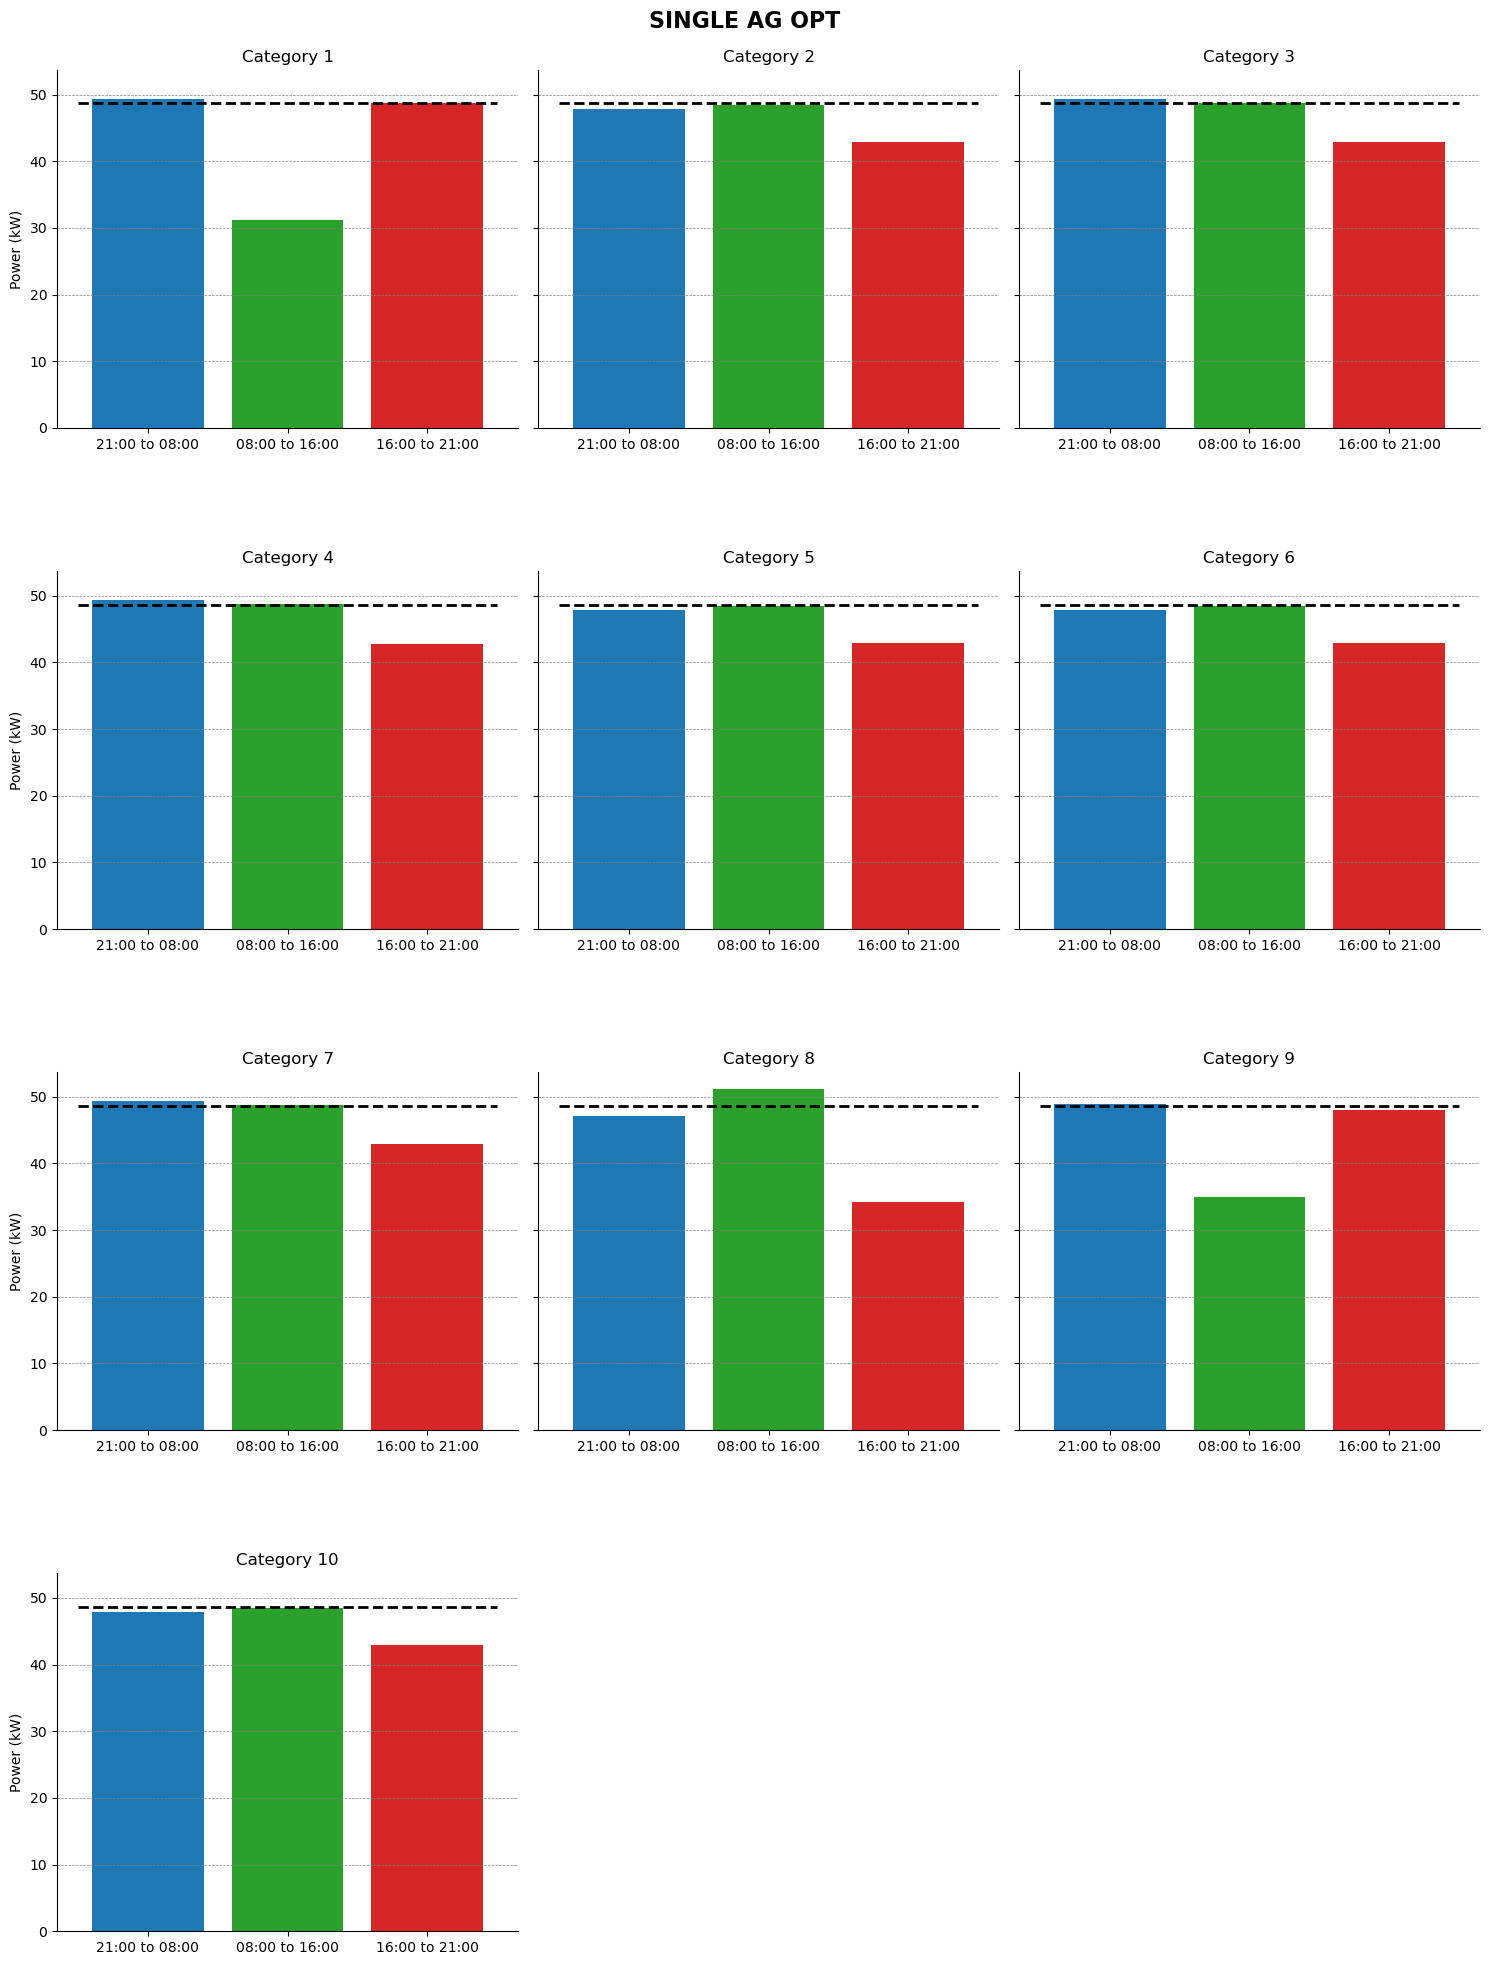

In [35]:
# Calculate the number of subplots based on the number of columns in the DataFrame
num_cols = overall_per_ag_sg_hourly.shape[1]
num_rows = int(np.ceil(num_cols / 3))  # Maximum of 3 columns per row

# Create subplots with shared y-axis
fig, axes = plt.subplots(nrows=num_rows, ncols=min(3, num_cols), figsize=(15, 5 * num_rows), sharey=True)

# Flatten axes array for easy iteration if there's more than one row
if num_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]

# Set the width of the bars to a higher value
bar_width = 0.8

per_ag_line_height = (line_heights / num_agents)[0]

# Plot each series in a subplot
for i, ax in enumerate(axes):
    if i < num_cols:  # Check if the current index is less than the number of columns in the DataFrame
        overall_per_ag_sg_hourly.iloc[:, i].plot(kind='bar', ax=ax, color=colors, title=f'Category {i + 1}', width=bar_width)
        ax.plot([-0.5, len(overall_per_ag_sg_hourly.index) - 0.5], [per_ag_line_height, per_ag_line_height], 'k--', lw=2, label='Adjusted Limit')  # Example value for the adjusted line height
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticklabels(overall_per_ag_sg_hourly.index, rotation=0)
        ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray', axis='y')
        ax.set_ylabel('Power (kW)')
    else:
        fig.delaxes(ax)  # Remove unused axes if there are less plots than axes

# Layout adjustment with reduced horizontal space
fig.suptitle('SINGLE AG OPT', fontsize=16, fontweight='bold')
plt.tight_layout()
fig.subplots_adjust(hspace=0.4)  # Adjust horizontal space between subplots
fig.subplots_adjust(top=0.95)  # You can adjust this value as needed for your specific display

plt.show()

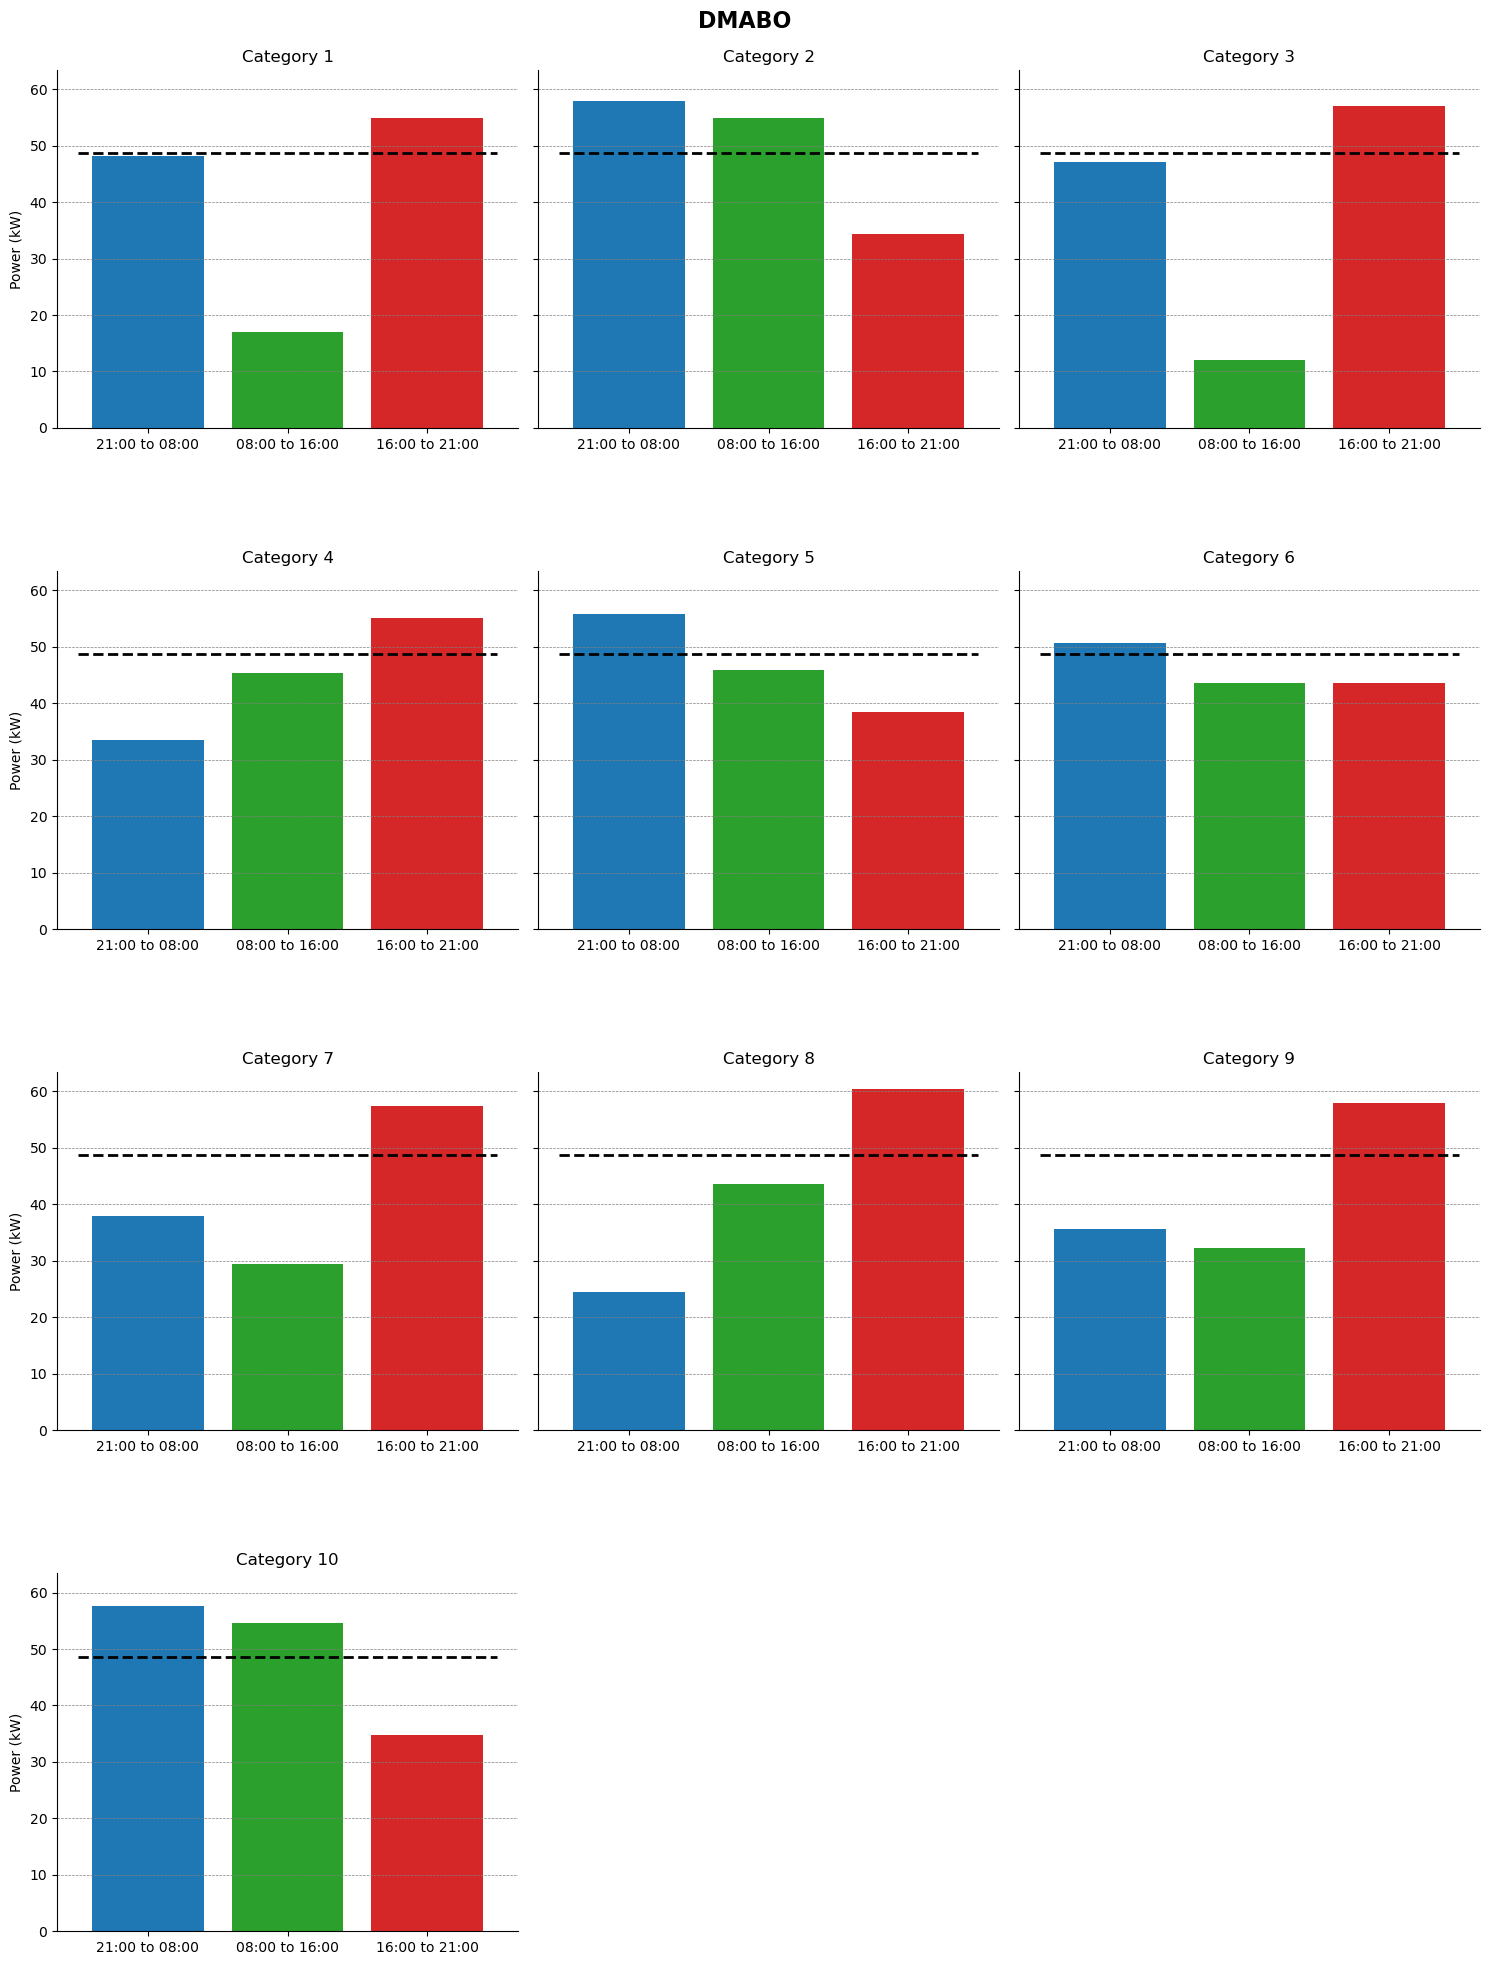

In [36]:
# Calculate the number of subplots based on the number of columns in the DataFrame
num_cols = overall_per_ag_hourly.shape[1]
num_rows = int(np.ceil(num_cols / 3))  # Maximum of 3 columns per row

# Create subplots with shared y-axis
fig, axes = plt.subplots(nrows=num_rows, ncols=min(3, num_cols), figsize=(15, 5 * num_rows), sharey=True)

# Flatten axes array for easy iteration if there's more than one row
if num_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]

# Set the width of the bars to a higher value
bar_width = 0.8

per_ag_line_height = (line_heights / num_agents)[0]

# Plot each series in a subplot
for i, ax in enumerate(axes):
    if i < num_cols:  # Check if the current index is less than the number of columns in the DataFrame
        overall_per_ag_hourly.iloc[:, i].plot(kind='bar', ax=ax, color=colors, title=f'Category {i + 1}', width=bar_width)
        ax.plot([-0.5, len(overall_per_ag_hourly.index) - 0.5], [per_ag_line_height, per_ag_line_height], 'k--', lw=2, label='Adjusted Limit')  # Example value for the adjusted line height
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticklabels(overall_per_ag_hourly.index, rotation=0)
        ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray', axis='y')
        ax.set_ylabel('Power (kW)')
    else:
        fig.delaxes(ax)  # Remove unused axes if there are less plots than axes

# Layout adjustment with reduced horizontal space
fig.suptitle('DMABO', fontsize=16, fontweight='bold')
plt.tight_layout()
fig.subplots_adjust(hspace=0.4)  # Adjust horizontal space between subplots
fig.subplots_adjust(top=0.95)  # You can adjust this value as needed for your specific display

plt.show()

Let's put a limit at 70 per agent and per period

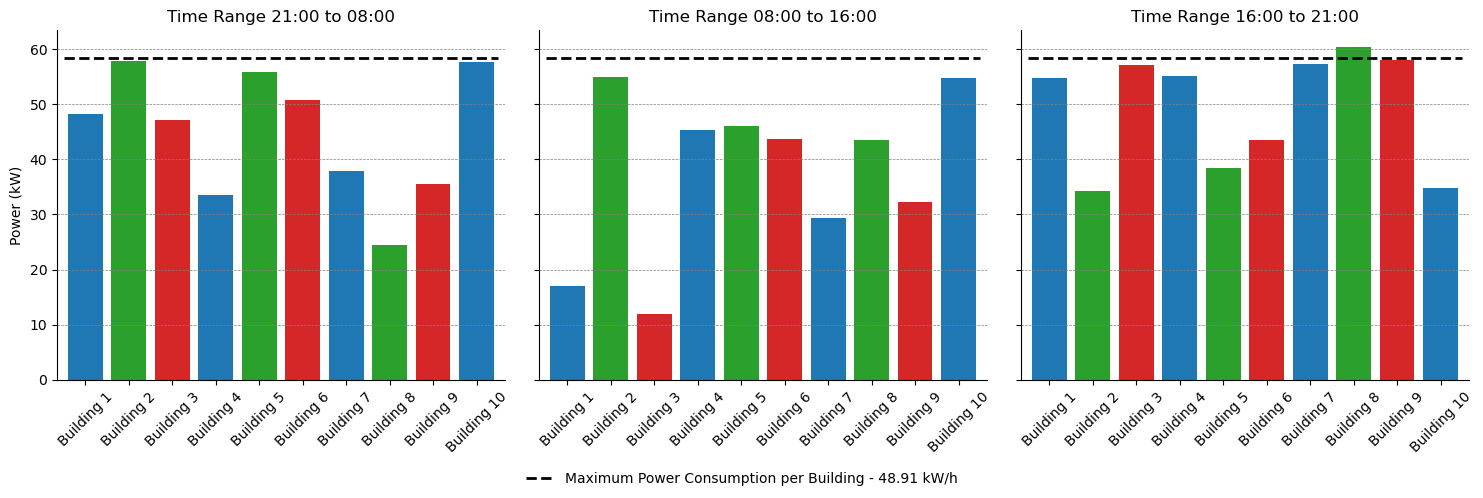

In [37]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming `overall_per_ag_hourly`, `num_agents`, `colors`, and `line_heights` are defined earlier in your code

# Number of time ranges (assuming the DataFrame index represents time ranges)
num_time_ranges = overall_per_ag_hourly.shape[0]
overall_per_ag_hourly.columns = [f'Building {i+1}' for i in range(num_agents)]

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

# Ensure axes is a flat array for easy iteration
axes = axes.flatten()

# Set the width of the bars
bar_width = 0.8

# Calculate the adjusted line height
per_ag_line_height = (line_heights / num_agents)[0]

# Plot each time range in a subplot
for i, ax in enumerate(axes):
    if i < num_time_ranges:
        # Get the time range and corresponding data
        time_range = overall_per_ag_hourly.index[i]
        data = overall_per_ag_hourly.iloc[i, :]
        
        # Plot the data
        data.plot(kind='bar', ax=ax, color=colors, title=f'Time Range {time_range}', width=bar_width)
        
        # Add the adjusted limit line
        limit_line = ax.plot([-0.5, len(data.index) - 0.5], 
                             [per_ag_line_height * 1.2, per_ag_line_height * 1.2], 
                             'k--', lw=2, label='Adjusted Limit')
        
        # Customize the subplot
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticklabels(data.index, rotation=45)  # Changed rotation from 0 to 45
        ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray', axis='y')
        ax.set_ylabel('Power (kW)')
    else:
        # Remove unused axes if any
        fig.delaxes(ax)

# Create a proxy artist for the legend
proxy_line = Line2D([0], [0], linestyle='--', color='k', lw=2)

# Add the global legend below the subplots
fig.legend([proxy_line], ['Maximum Power Consumption per Building - 48.91 kW/h'],
           loc='lower center', ncol=1, frameon=False, fontsize='medium')

# Adjust the layout to make space for the legend
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at the bottom for the legend
# Alternatively, you can adjust `rect` values as needed

# Optionally adjust the top to make space for a suptitle if needed
# fig.subplots_adjust(hspace=0.4, top=0.95)

# Display the plot
plt.show()


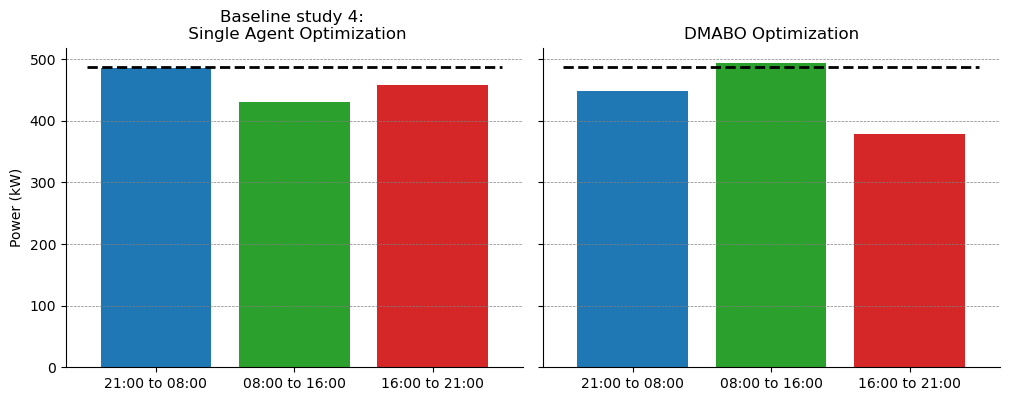

In [38]:
import matplotlib.pyplot as plt

# Assume hour_20, hour_21, hour_22, hour_singopt are pandas Series or DataFrames
# Colors for each category index
colors = ['#1f77b4', '#2ca02c', '#d62728']  # more professional color scheme

# Create subplots with shared y-axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

# Set the width of the bars to a higher value
bar_width = 0.8  # Adjust this value as needed to make bars thicker and closer

# Plot each series in a subplot with specified colors for each category index
hour_singopt.plot(kind='bar', ax=axes[0], color=colors, title='Baseline study 4: \n Single Agent Optimization', width=bar_width)
hour_dmabo.plot(kind='bar', ax=axes[1], color=colors, title='DMABO Optimization', width=bar_width)

line_heights = adjusted_values.values

# Adding dashed lines at specified heights
axes[0].plot([- 0.5, 2.5], [line_heights[0], line_heights[0]], 'k--', lw=2, label='Adjusted Limit')
axes[1].plot([- 0.5, 2.5], [line_heights[0], line_heights[0]], 'k--', lw=2, label='Adjusted Limit')

# Layout adjustment with reduced horizontal space
plt.tight_layout()  # Adjust the h_pad to reduce spacing
fig.subplots_adjust(hspace=0.4)  # Lower value means less space

# Remove top and right spines and add horizontal grid lines for all subplots
for ax in axes.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray', axis='y')
    ax.set_ylabel('Power (kW)')

fig.savefig('bars_dmabo_power.eps', format='eps', bbox_inches='tight')

plt.show()
